# Let's play around with some WoW data!
This dataset represents one year of observations in 2008 for ~30,000 avatars in World of Warcraft. These observations include the level, location, guild, race, and class of each avatar at a given instance in time. Our goal here is to explore this data for any interesting relationships with one overarching goal in mind: can we build a predictive model that would allow one to determine whether or not some avatar will achieve the max level given its play history?

In [1]:
#First import necessary stuff
#Import stuff
#Data wrangling
import pandas as pd
#We don't like infinities, so set those to null
pd.set_option('mode.use_inf_as_null', True)
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Pickling for saving progress
import cPickle

#Machine learning
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import precision_recall_fscore_support

#Constants
#Max level before WLK
MAX_LEVEL1 = 70
#Max level after
MAX_LEVEL2 = 80
#Release of the Wrath of the Lich King expansion
WLK_RD = pd.to_datetime('11/18/2008')

In [2]:
#Any functions we want to use
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve. All credit for this function goes to the 
    scikit-learn team. Code was swiped from here: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Load and wrangle data

In [3]:
#Load data
wow_df = pd.read_csv('wowah_data.csv')

Get some basic info from the data

In [4]:
wow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
char          int64
 level        int64
 race         object
 charclass    object
 zone         object
 guild        int64
 timestamp    object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


And some basic stats

In [5]:
wow_df.describe()

,char,level,guild
count,1.082673e+07,1.082673e+07,1.082673e+07
mean,4.374145e+04,6.130605e+01,1.370670e+02
std,2.544662e+04,1.818301e+01,1.133178e+02
min,2.000000e+00,1.000000e+00,-1.000000e+00
25%,2.247600e+04,6.200000e+01,3.500000e+01
50%,4.616900e+04,7.000000e+01,1.030000e+02
75%,6.643600e+04,7.000000e+01,2.040000e+02
max,9.058000e+04,8.000000e+01,5.080000e+02


In [6]:
wow_df.describe(include=['O'])

,race,charclass,zone,timestamp
count,10826734,10826734,10826734,10826734
unique,5,10,158,1826400
top,Blood Elf,Hunter,Shattrath City,03/22/08 00:29:36
freq,3929995,1549924,1105269,88


In [7]:
wow_df.columns.values

array(['char', ' level', ' race', ' charclass', ' zone', ' guild',
       ' timestamp'], dtype=object)

In [8]:
#Note that some column names have added whitespace. Strip that whitespace for clarity now
for c in wow_df.columns:
    c = c.lstrip()
    
wow_df.columns = [x.lstrip() for x in wow_df.columns.values]    

#Verify it worked
wow_df.columns.values

array(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype=object)

In [9]:
#Having all the unique character names will be useful later
chars = np.sort(wow_df.char.unique())
nav = np.size(chars)
10826733 / nav

#Also, let's find the number of unique guilds
guilds = np.sort(wow_df.guild.unique())
ng = np.size(guilds)

#Also, let's find the number of unique locations
locs = np.sort(wow_df.zone.unique())
nl = np.size(locs)

So we have ~300 data points per avatar. Now let's explore the properties of the time sampling. For this, we need to convert the timestamp column to a numerical value. 

Since there is a boatload of data, let's first estimate how long it's going to take to convert all to timestamps

In [10]:
%time pd.to_datetime(wow_df.timestamp[0])

800e-6 * 10826733 / 60 / 60

CPU times: user 36.7 ms, sys: 7.32 ms, total: 44 ms
Wall time: 42.4 ms


2.405940666666667

So it's going to take a long time to convert the timestamps on my machine. In this case, let's save the converted timestamps to a pickled object so that we don't have to do this everytime we run this code.

In [11]:
#Now let's convert the timestamp column to numerical values
#First check if it's already been done
try:
    with open('timestamps.pkl', 'rb') as f:
        dts = cPickle.load(f)
except IOError:
    dts = pd.to_datetime(wow_df['timestamp'])

    with open('timestamps.pkl', 'wb') as f:
        cPickle.dump(dts, f)
        
#Just replace old timestamp column since it's no longer necessary 
wow_df['timestamp'] = dts

#See that it did indeed make timestamp a pandas timestamp object
wow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
char         int64
level        int64
race         object
charclass    object
zone         object
guild        int64
timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 578.2+ MB


Let's try plotting a level curve for one player to examine how they progressed.

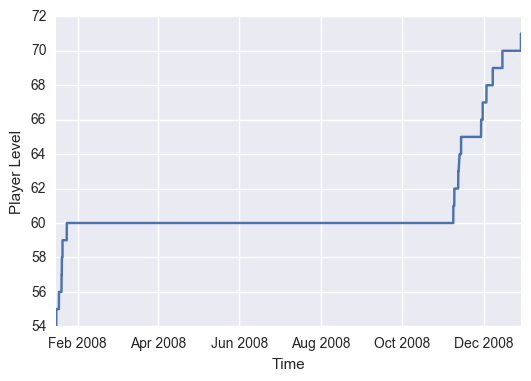

In [12]:
av = wow_df.loc[wow_df['char'] == chars[1]]

#Find where max level is reached since curve is pretty boring after that
prog = av[av['level'] < MAX_LEVEL2]

plt.plot(prog['timestamp'], prog['level'])
plt.xticks(['02-2008', '04-2008', '06-2008', '08-2008', '10-2008', '12-2008'], 
           ['Feb 2008', 'Apr 2008', 'Jun 2008', 'Aug 2008', 'Oct 2008', 'Dec 2008'])
plt.xlabel('Time')
plt.ylabel('Player Level')

It looks like this avatar was level ~54 when the observations began, and progressed to close to the max level in about a year with a long hiatus. This hiatus corresponds to the original WoW level cap, and the progression from this level begins when Wrath of the Lich King was released. It might be interesting to look at playtime after max level is reached and what else happens after they reach max level. For now, let's see if we can say anything about how these level curves correlate with other player behavior.

# Distilling the data on an avatar-by-avatar basis
Since we are looking for variations in level progression across a broad range of levels and times, we want to come up with some features that describe the progression of level and play over time. So, let's go through each avatar and see if it reached max level. We will also create a new dataframe called av_df to store static quantities for each avatar. These will include otther useful things, like average level, max level, level range, whether or not the avatar changed guilds at all, modular guild, and most frequented location.

Basically, at the end of the day we want to characterize the variations in avatar level and see if these variations correlate with any other avatar properties.

In [13]:
#Make the new dataframe for progression quantities
av_df = pd.DataFrame({'char': chars}).sort_values(by='char')

#Note that as another exploration for this dataset has found:
#(https://www.kaggle.com/romainvincent/d/mylesoneill/warcraft-avatar-history/exploration)
# that here seems to be several avatars that mysteriously change race throughout the observations.
#So we want to also calculate the number of unique races and classes for each avatar as well
#Number of races per avatar
av_df = av_df.merge(wow_df[['char', 'race']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_df = av_df.rename(columns={'race':'nrace'})
#Number of classes per avatar
av_df = av_df.merge(wow_df[['char', 'charclass']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_df = av_df.rename(columns={'charclass':'ncharclass'})


#Inclue the race and character class
av_df = av_df.merge(wow_df[['char', 'race']].groupby(['char'], as_index=False).agg(
        lambda x: x.value_counts().index[0]), on='char')
av_df = av_df.merge(wow_df[['char', 'charclass']].groupby(['char'], as_index=False).agg(
        lambda x: x.value_counts().index[0]), on='char')

#Get mean levels and merge with av_df
av_df = av_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False).mean(), on='char')
#And rename column to be more appropriate
av_df = av_df.rename(columns={'level':'avglvl'})

#Max level
av_df = av_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False).max(), on='char')
#And rename column to be more appropriate
av_df = av_df.rename(columns={'level':'maxlvl'})

#Reach max level?
av_df = av_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False)\
                    .agg(lambda x: np.size(np.where(x >= MAX_LEVEL2)[0]) > 0), on='char')
#And rename column to be more appropriate
av_df = av_df.rename(columns={'level':'maxlvld'})

#Reach max level prior to WLK?
av_df = av_df.merge(wow_df.loc[wow_df['timestamp'] < WLK_RD, ['char', 'level']].groupby(['char'], as_index=False)\
                    .agg(lambda x: np.size(np.where(x >= MAX_LEVEL1)[0]) > 0), how='left', on='char')
#And rename column to be more appropriate
av_df = av_df.rename(columns={'level':'maxlvld_preWLK'})

#Level range
av_df = av_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
#And rename column to be more appropriate
av_df = av_df.rename(columns={'level':'lvlrng'})

#Number unique of guilds
av_df = av_df.merge(wow_df[['char', 'guild']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_df = av_df.rename(columns={'guild':'nguild'})

#Most frequented guild
av_df = av_df.merge(wow_df[['char', 'guild']].groupby(['char'], as_index=False).agg(lambda x: x.value_counts().index[0]),
            on='char')
av_df = av_df.rename(columns={'guild':'modguild'})

#Most frequented location
av_df = av_df.merge(wow_df[['char', 'zone']].groupby(['char'], as_index=False).agg(lambda x: x.value_counts().index[0]), 
            on='char')
av_df = av_df.rename(columns={'zone':'modzon'})

#Number unique of locations
av_df = av_df.merge(wow_df[['char', 'zone']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_df = av_df.rename(columns={'zone':'nzon'})

#Number of data points for this avatar (i.e. frequency of playing)
av_df = av_df.merge(pd.DataFrame(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).count()), on='char')
av_df = av_df.rename(columns={'timestamp':'nplays'})

#Last recorded play timestamp
av_df = av_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).max(), on='char')
av_df = av_df.rename(columns={'timestamp':'lastplay'})

#First recorded play timestamp
av_df = av_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).min(), on='char')
av_df = av_df.rename(columns={'timestamp':'firstplay'})

#And total time baseline
av_df = av_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
av_df = av_df.rename(columns={'timestamp':'baseline'})
#Convert this time delta to just a float number of days
av_df['baseline_td'] = av_df['baseline'].dt.total_seconds() / (24 * 60 * 60)

#Also want to know time spent actually progressing before max level was reached
av_df = av_df.merge(wow_df.loc[wow_df['level'] < MAX_LEVEL2, 
                               ['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
av_df = av_df.rename(columns={'timestamp':'prog_baseline'})
av_df['prog_baseline_td'] = av_df['prog_baseline'].dt.total_seconds() / (24 * 60 * 60)

#Also, want to know if avatar stopped playing before Wrath of the Lich King expansion was released
av_df = av_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: np.size(np.where(x >= WLK_RD)[0]) <= 0), on='char')
av_df = av_df.rename(columns={'timestamp':'preWLK'})

#Also, want to know if avatar started playing after Wrath of the Lich King expansion was released
av_df = av_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: np.size(np.where(x < WLK_RD)[0]) <= 0), on='char')
av_df = av_df.rename(columns={'timestamp':'postWLK'})

In [14]:
av_df.info()
av_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37349 entries, 0 to 37348
Data columns (total 23 columns):
char                37349 non-null int64
nrace               37349 non-null int64
ncharclass          37349 non-null int64
race                37349 non-null object
charclass           37349 non-null object
avglvl              37349 non-null float64
maxlvl              37349 non-null int64
maxlvld             37349 non-null bool
maxlvld_preWLK      32537 non-null object
lvlrng              37349 non-null int64
nguild              37349 non-null int64
modguild            37349 non-null int64
modzon              37349 non-null object
nzon                37349 non-null int64
nplays              37349 non-null int64
lastplay            37349 non-null datetime64[ns]
firstplay           37349 non-null datetime64[ns]
baseline            37349 non-null timedelta64[ns]
baseline_td         37349 non-null float64
prog_baseline       37349 non-null timedelta64[ns]
prog_baseline_td    37349 

,char,nrace,ncharclass,race,charclass,avglvl,maxlvl,maxlvld,maxlvld_preWLK,lvlrng,...,nzon,nplays,lastplay,firstplay,baseline,baseline_td,prog_baseline,prog_baseline_td,preWLK,postWLK
count,37349.000000,37349.000000,37349.000000,37349,37349,37349.000000,37349.000000,37349,32537,37349.000000,...,37349.000000,37349.000000,37349,37349,37349,37349.000000,37349,37349.000000,37349,37349
unique,NaN,NaN,NaN,5,10,NaN,NaN,2,2,NaN,...,NaN,NaN,31279,30148,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,Blood Elf,Warrior,NaN,NaN,False,False,NaN,...,NaN,NaN,2008-12-31 23:50:18,2008-11-19 13:09:50,NaN,NaN,NaN,NaN,True,False
freq,NaN,NaN,NaN,12477,7530,NaN,NaN,36470,28414,NaN,...,NaN,NaN,35,25,NaN,NaN,NaN,NaN,26783,32537
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2008-01-01 00:15:00,2008-01-01 00:02:04,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2008-12-31 23:50:18,2008-12-31 23:15:20,NaN,NaN,NaN,NaN,NaN,NaN
mean,63450.364026,1.013950,1.021045,NaN,NaN,18.342052,20.466385,NaN,NaN,6.047498,...,9.830571,289.869421,NaN,NaN,72 days 14:38:04.271707,72.609772,72 days 04:14:25.373316,72.176683,NaN,NaN
std,24402.234494,0.127562,0.172043,NaN,NaN,24.378478,26.125945,NaN,NaN,13.175718,...,20.301872,957.067526,NaN,NaN,116 days 17:27:39.431948,116.727540,116 days 00:01:49.957291,116.001273,NaN,NaN
min,2.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000,NaN,NaN
25%,52793.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,...,1.000000,2.000000,NaN,NaN,0 days 00:09:36,0.006667,0 days 00:09:36,0.006667,NaN,NaN


So now we have a new dataframe that contains one row per avatar with some aggregate properties for each. We now want to clean the data up. As other explorations of this data have shown, there are some problematic avatars. First, a significant fraction of them logged on for only one play. Given that we want to explore time evolution with this dataset, singly observed avatars will not tell us much. Thus, we want to get rid of these. Additionally, many avatars show mysterious race/class swaps even though these data predate race swapping in WoW. It is unclear whether these race and class swaps are real, or whether they reflect inconsistencies in the data. In any case, such swaps will likely muddy the waters for some insights to gain in terms of race/class dependencies, so we will also remove all characters  which show more than one race or class.

In [15]:
#Remove singly observed avatars
av_df = av_df[av_df['nplays'] > 1]
#Remove race changing avatars
av_df = av_df[av_df['nrace'] == 1]
#Remove class changing avatars
av_df = av_df[av_df['ncharclass'] == 1]

av_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27574 entries, 1 to 37345
Data columns (total 23 columns):
char                27574 non-null int64
nrace               27574 non-null int64
ncharclass          27574 non-null int64
race                27574 non-null object
charclass           27574 non-null object
avglvl              27574 non-null float64
maxlvl              27574 non-null int64
maxlvld             27574 non-null bool
maxlvld_preWLK      24195 non-null object
lvlrng              27574 non-null int64
nguild              27574 non-null int64
modguild            27574 non-null int64
modzon              27574 non-null object
nzon                27574 non-null int64
nplays              27574 non-null int64
lastplay            27574 non-null datetime64[ns]
firstplay           27574 non-null datetime64[ns]
baseline            27574 non-null timedelta64[ns]
baseline_td         27574 non-null float64
prog_baseline       27574 non-null timedelta64[ns]
prog_baseline_td    27574 

So there were almost 10,000 problematic avatars. That effectively reduces our dataset by 1/3. Still, we should still be able to look for interesting relationships with this cleaned dataset.

# Race and class
Now let's see if there are any trends in terms of max leveling with race or class. Each race and class has its unqiue abilities which we expect should affect the level progression of avatars. Let us explore the existence of these correlations with some plots. The following plots will show the fraction of avatars in a given class-race combination that reached max level (level 80).

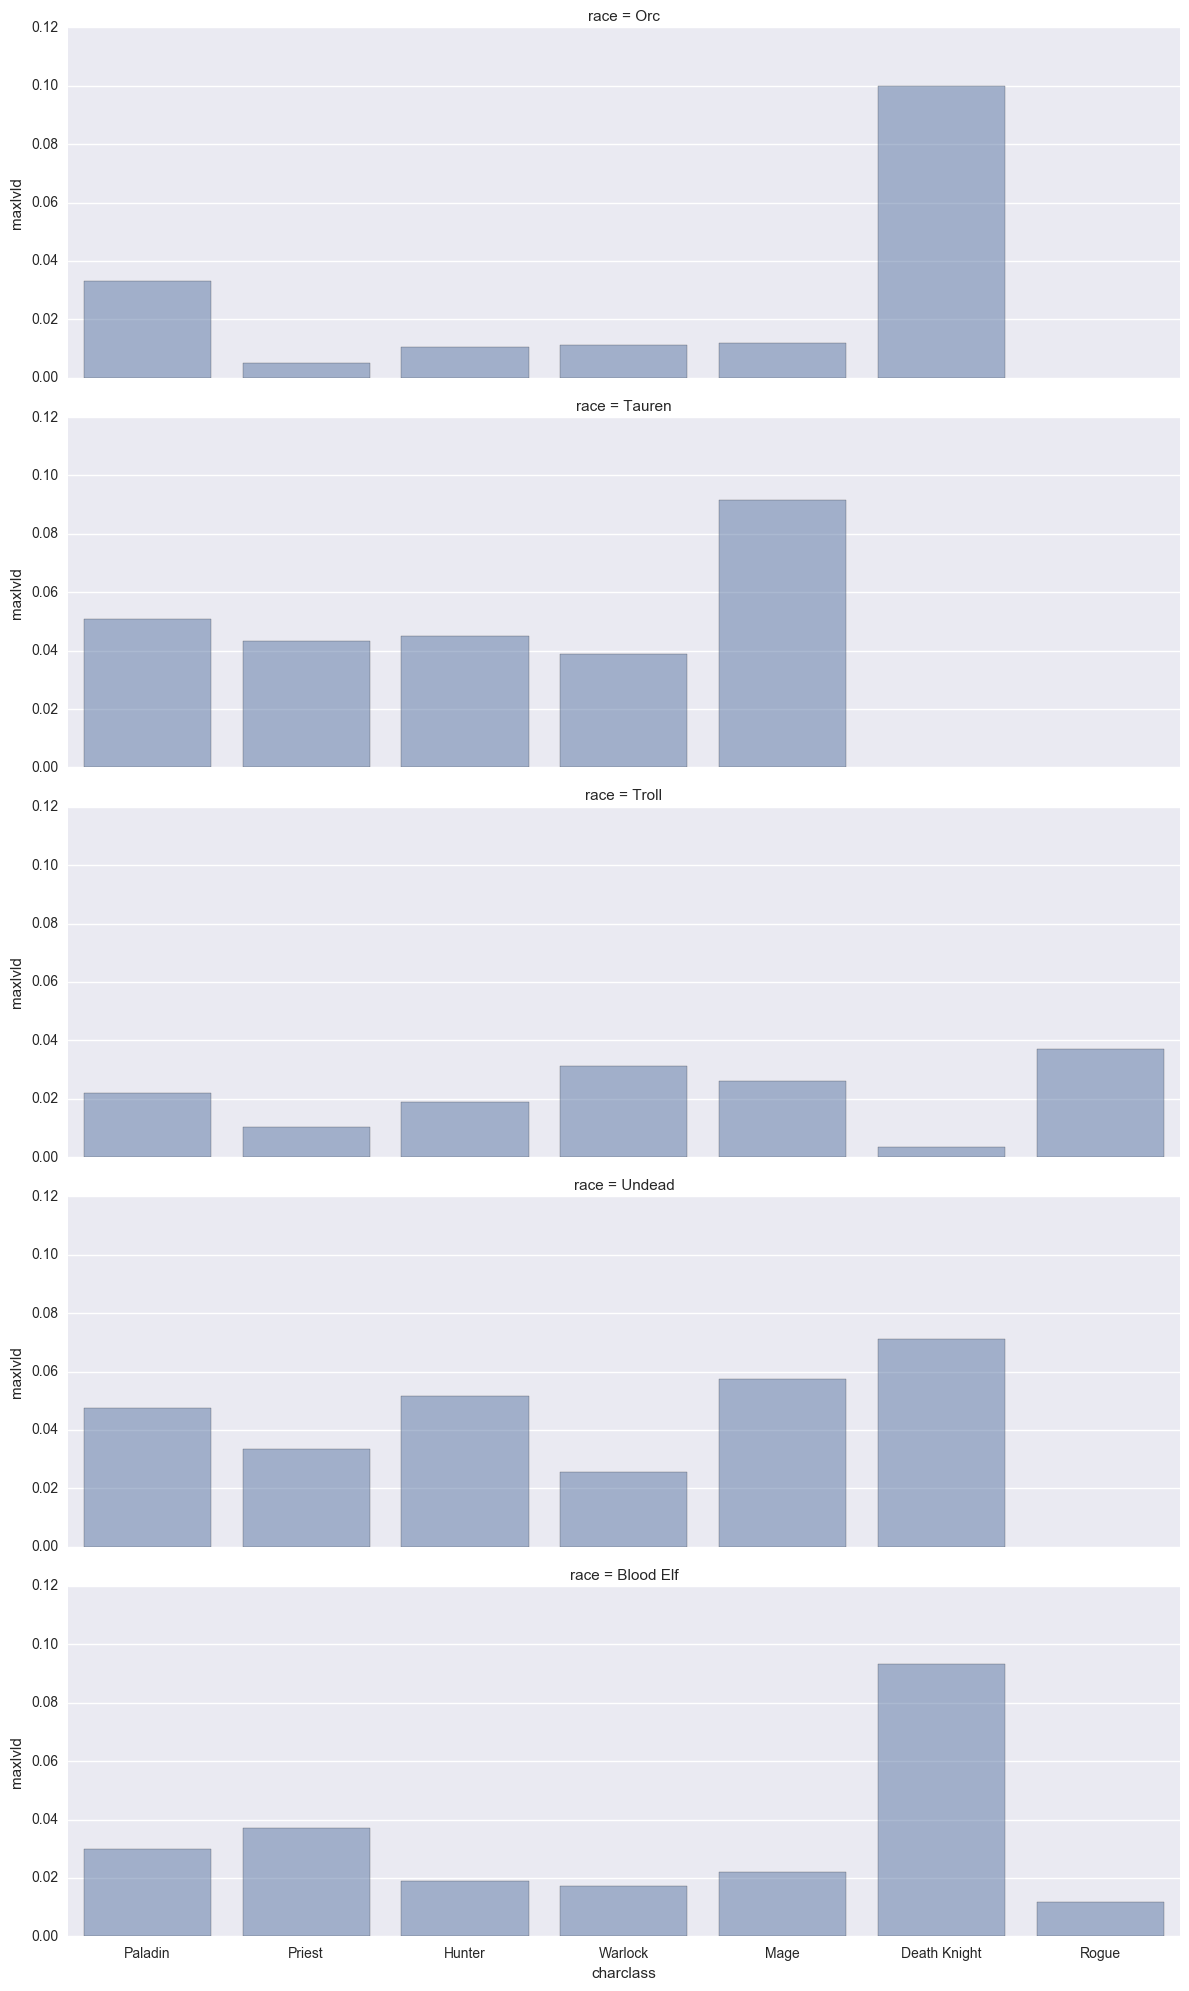

In [16]:
grid = sns.FacetGrid(av_df, row='race', size=4, aspect=3)
grid.map(sns.barplot, 'charclass','maxlvld', alpha=.5, ci=None)

So it does indeed look like whether or not an avatar reached max level depends on both the race and class. Death Knights particularly appear to prefer reaching max level across race lines. This probably reflects the fact that the Wrath of the Lich King was released during this dataset, and thus this class had the 'new' factor causing many players to level their first Death Knight. We also see race specific preferences, such as the Troll Rogue, Tauren Mage, and Orc Paladin. We can explore the effects of WLK expansion on this by splitting up by pre-WLK avatars.

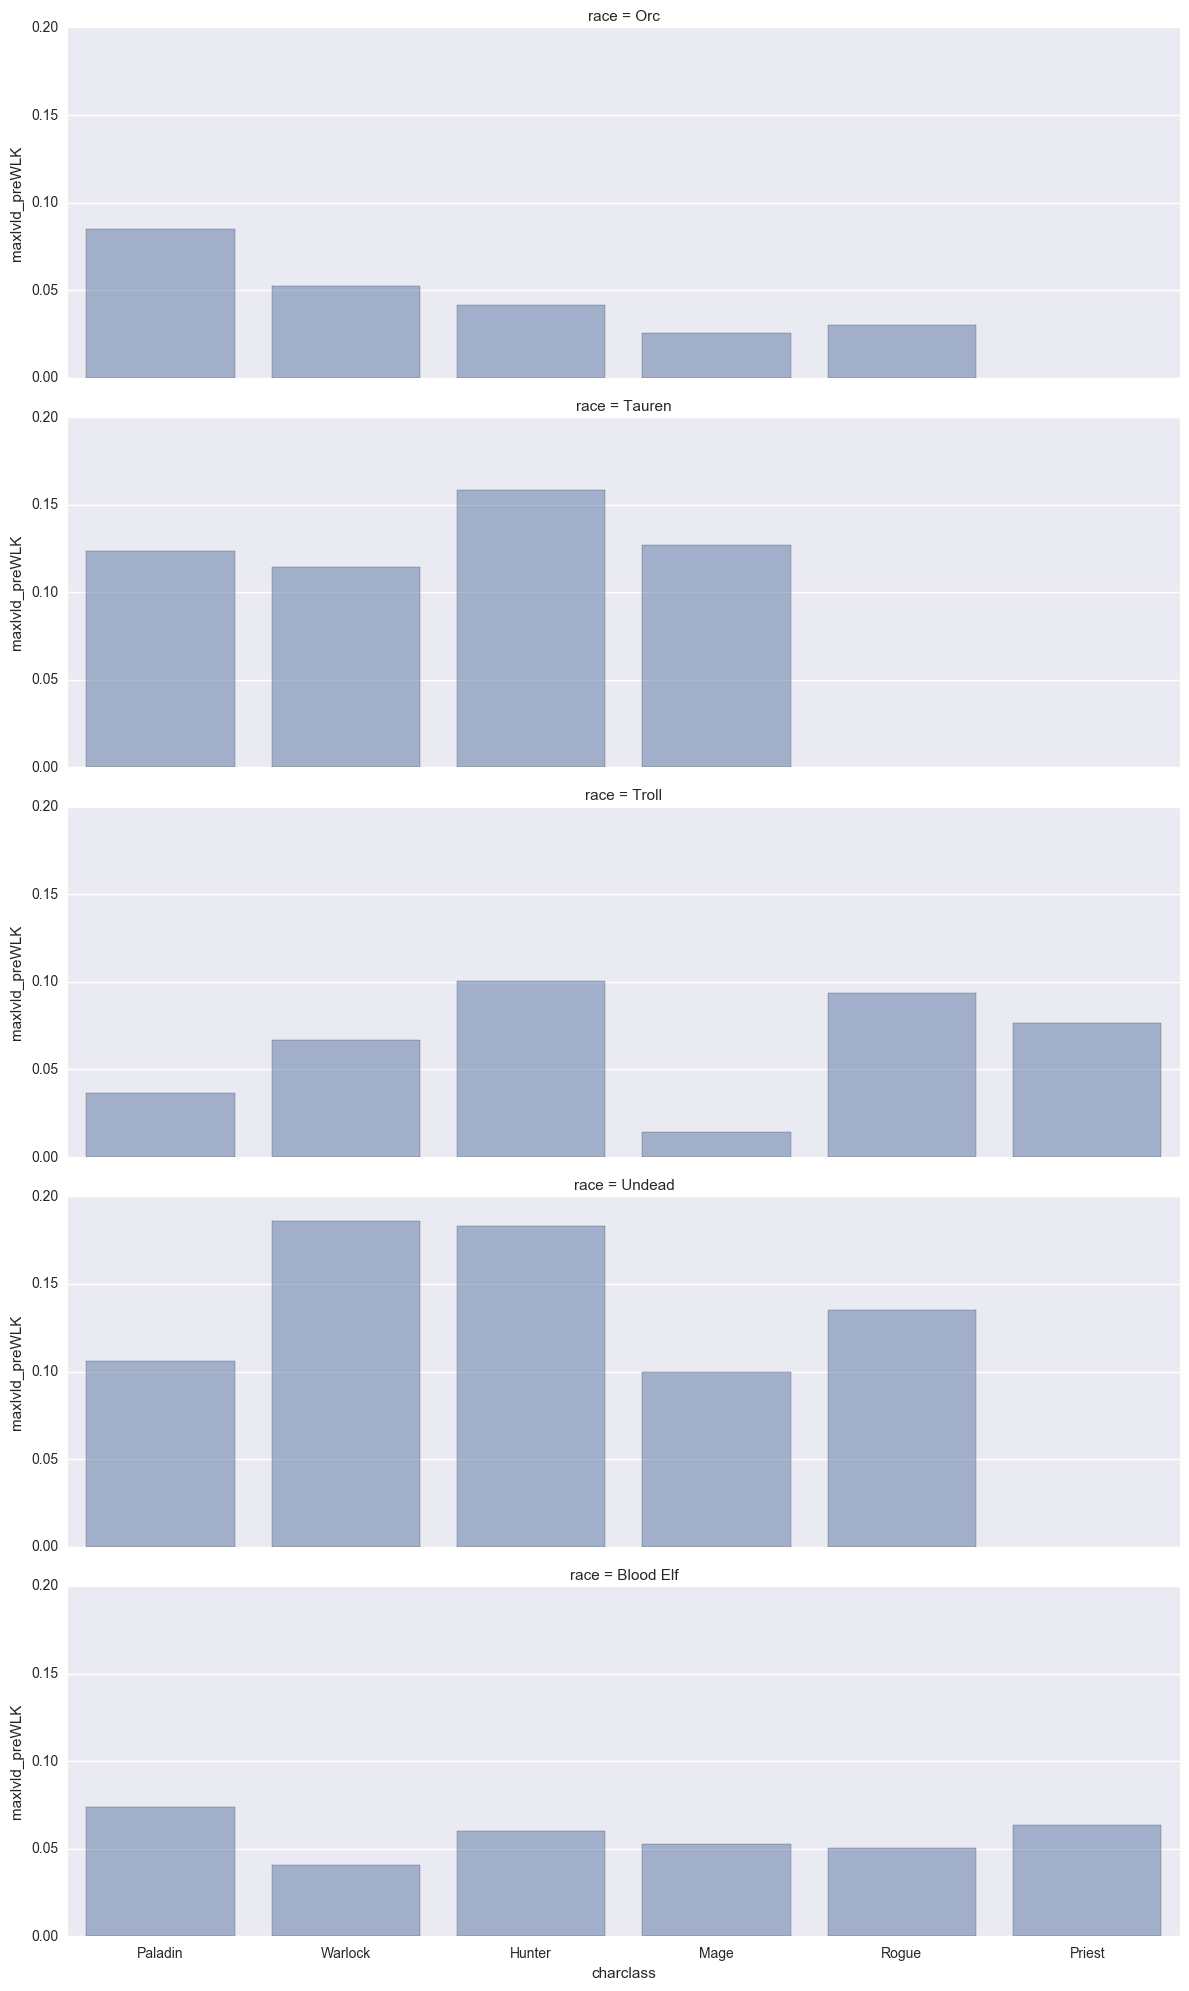

In [17]:
#Avatars which were played exclusively prior to WLK expansion
grid = sns.FacetGrid(av_df.loc[av_df['preWLK']], row='race', size=4, aspect=3)
grid.map(sns.barplot, 'charclass', 'maxlvld_preWLK', alpha=.5, ci=None)

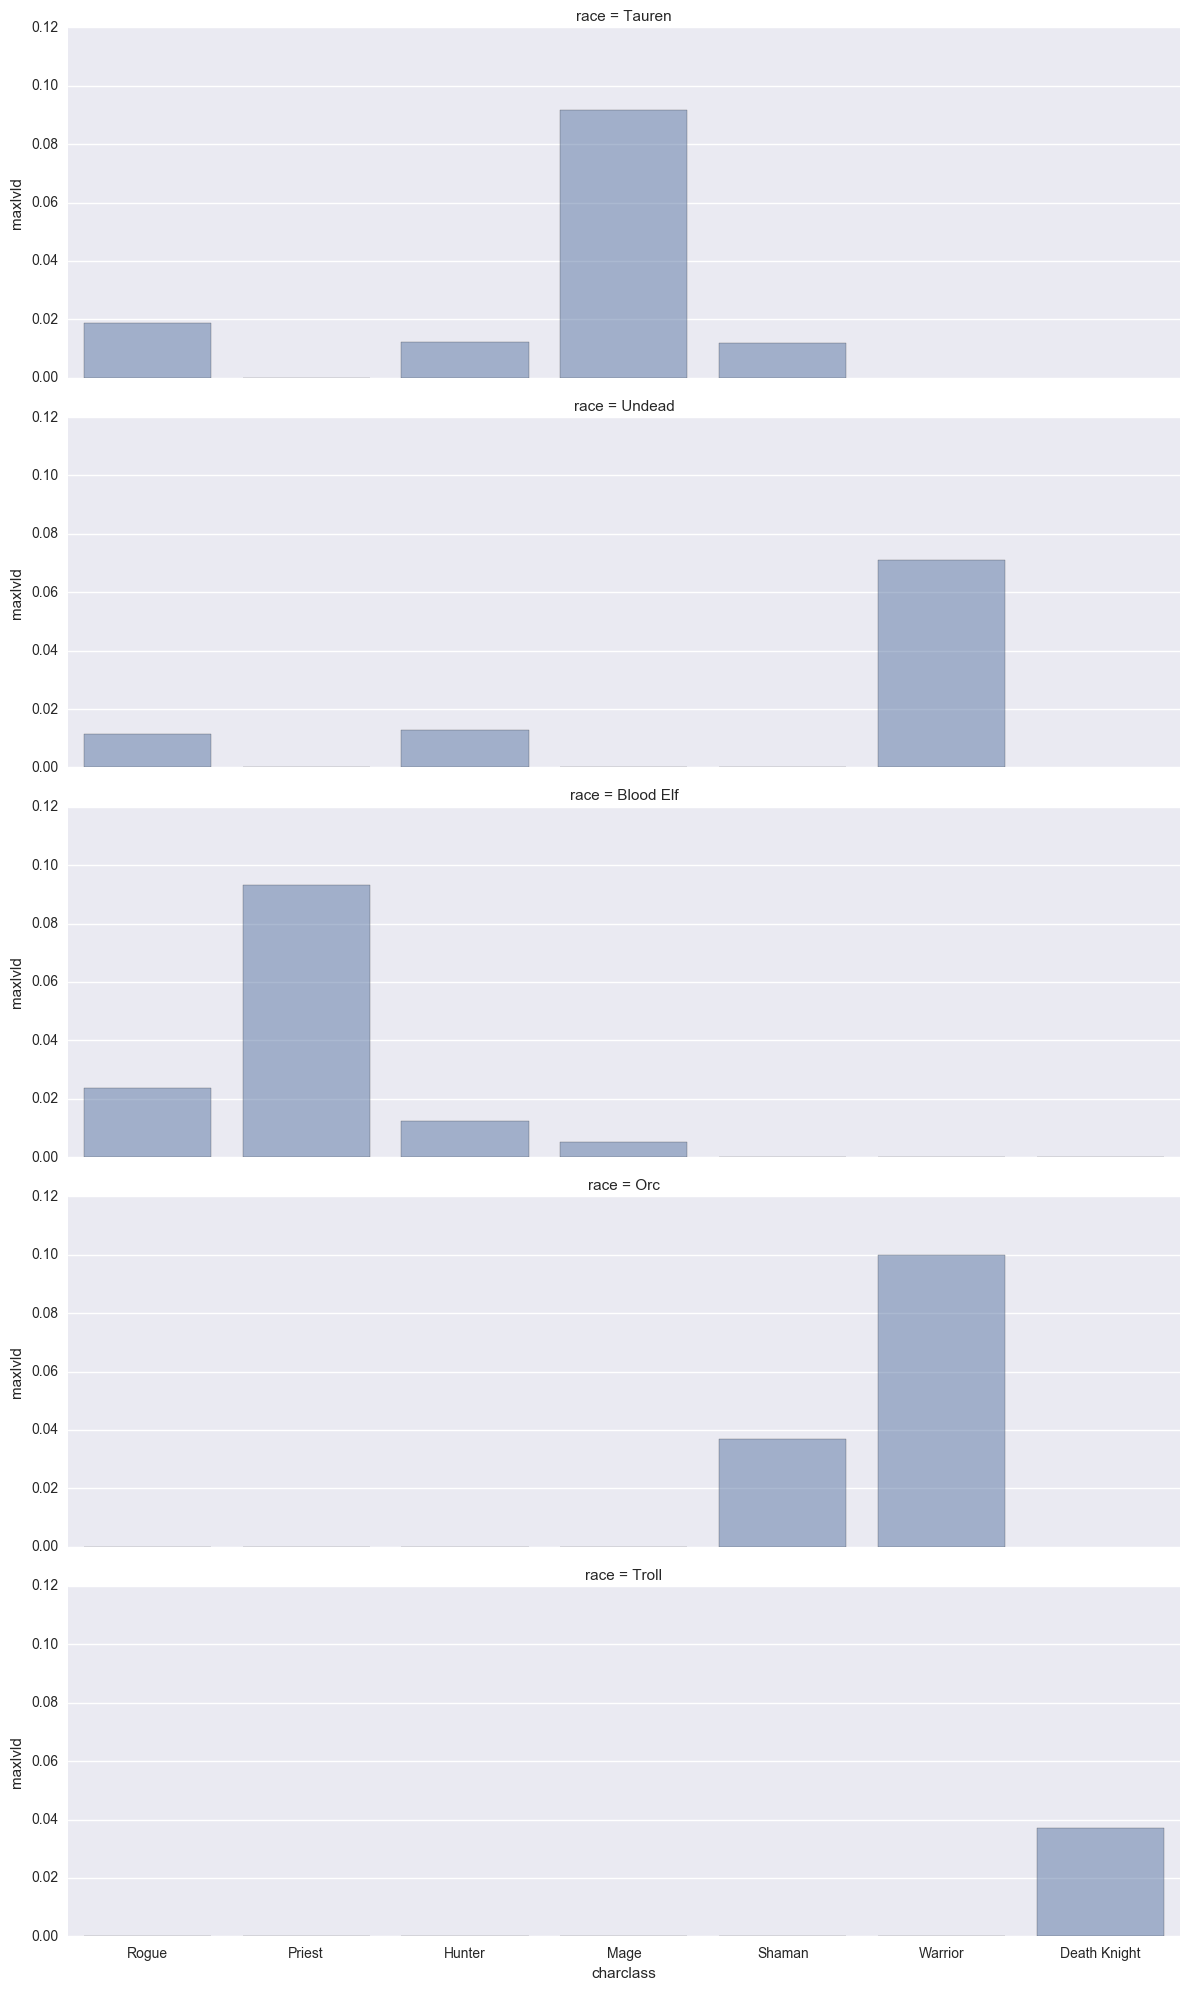

In [18]:
#Avatars which were played exclusively after to WLK expansion
grid = sns.FacetGrid(av_df.loc[av_df['postWLK']], row='race', size=4, aspect=3)
grid.map(sns.barplot, 'charclass', 'maxlvld', alpha=.5, ci=None)

Clearly, the distributions of avatars reaching max level is very different pre and post expansion. However, we must also consider the poorer statistics in the post-WLK avatars given the short time coverage of this phase (~1 month). Nevertheless, we should probably take into account this factor when considering if an avatar reaches max level. Interestingly, no warriors or shamans show up in the pre-WLK data. It is not entirely clear why this should be so. I suspect this might have something to do with the multiple race and class avatars that I cleaned from the data. Again, assuming that those avatars had some problems, then it follows that for some reason, warriors and shamans were more severely affected by these problems than other classes.

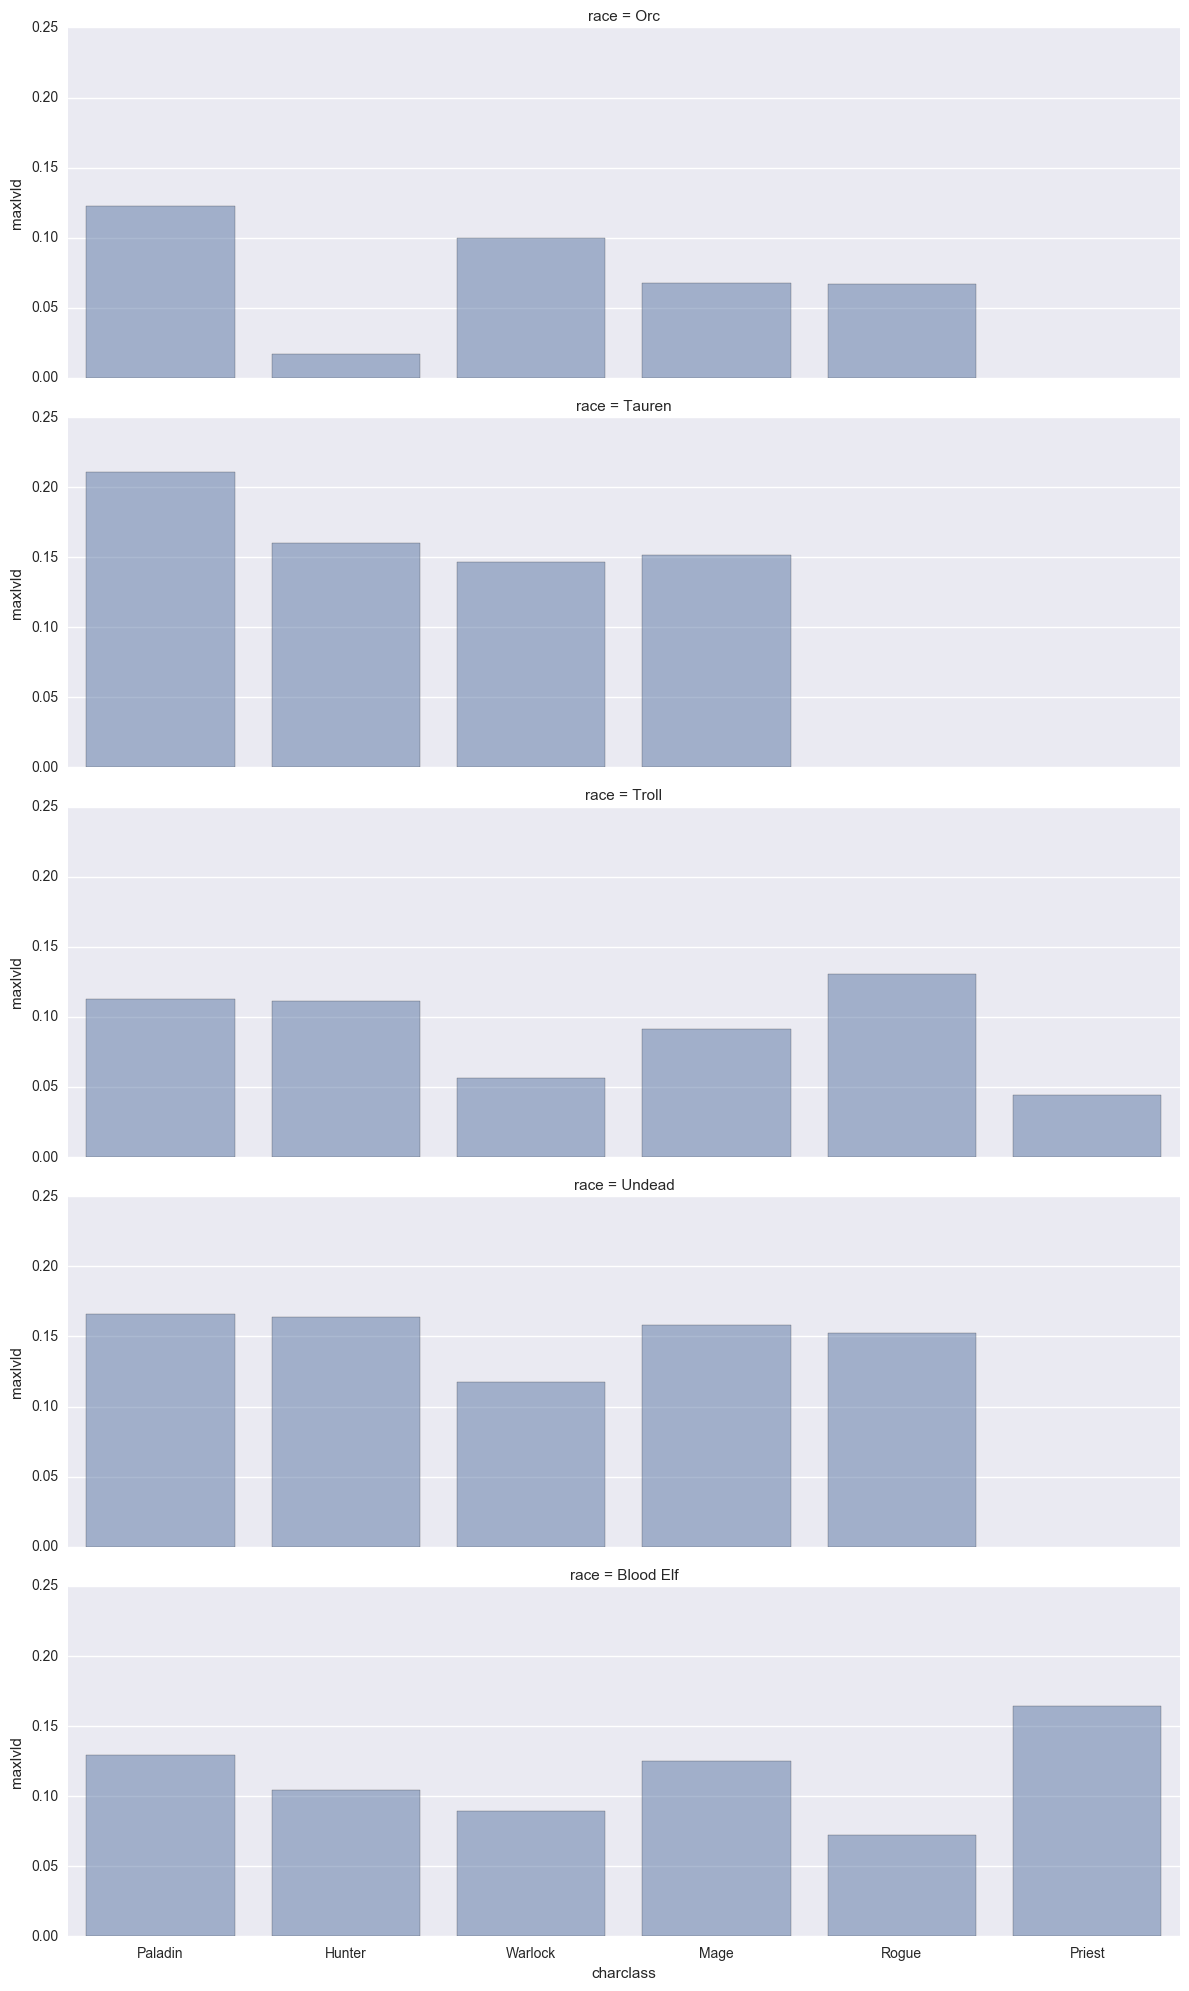

In [19]:
#Avatars which were played both before and after WLK expansion
grid = sns.FacetGrid(av_df.loc[(~av_df['postWLK']) & (~av_df['preWLK'])], row='race', size=4, aspect=3)
grid.map(sns.barplot, 'charclass', 'maxlvld', alpha=.5, ci=None)

Finally, it appears that avatars that were played before and after WLK expansion resembles some combination of the two exclusive groups.

# Amount of play
Does the amount of time and number of times played correlate with whether or not an avatar reaches max level? We might intuitively expect it to, but let's check it out in detail with some plots.

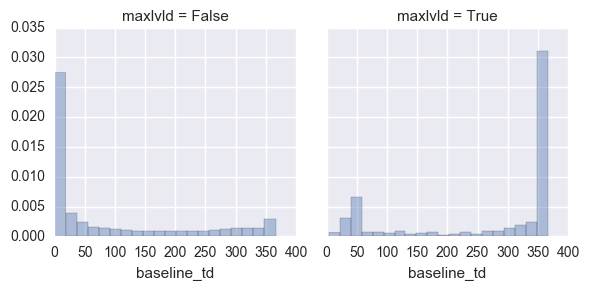

In [20]:
# We might expect the frequency of max leveling to increase with both time baseline and number of plays, 
# which are both measures of amount of gameplay.
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'baseline_td', bins=20, kde=False, norm_hist=True)

As expected, the total time baseline for play correlates strongly with whether or not an avatar achieved max level. Let's see if the same holds true for number of plays sampled. Aside from the simple intuitive correlation, we also observe a secondary peak in max-leveled avatars with time baselines of ~30-40 days. Again, we can understand this peak by factoring in the Wrath of the Lick King expansion release on November 13, 2008. This corresponds to ~40 days before the last observation in this dataset, thus this peak represents players who picked the game up following the release of this expansion and leveling up their avatar. We also see a rise in non-max-leveled avatars around this timeframe too, seemingly indicating a fair amount of avatars that started playing after the expansion was released but still did not reach max level. Finally, the non-max-leveled distribution displays a gradual rise and secondary peak near the total time baseline of the observations. We interpret these avatars as those who were droppped for some time before the expansion was released, and then picked up again after expansion without reaching max level.

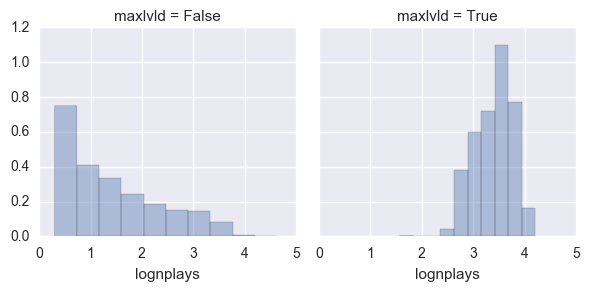

In [21]:
#Make nplays log scaled given the huge range
av_df['lognplays'] = np.log10(av_df['nplays'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognplays', bins=10, kde=False, norm_hist=True)

We again see quite different nplay distributions for avatars who reached max level compared with those who don't. Specifically, the max-leveled avatars were played on average a few thousand times. On the other hand, the non-max leveled avatars were leveled up significantly less than 1000 times. The max-leveled distribution resembles a (perhaps skewed) lognormal distribution, while the non-max-leveled resembles more a Poisson distribution. 

## Play rate
We can combine the above two features and calculate an average 'rate' of play. Essentially, we will divide the number of plays by the total time baseline. This will give us an idea how frequently each avatar was played. We expect that the play rate is correlated with max leveling.

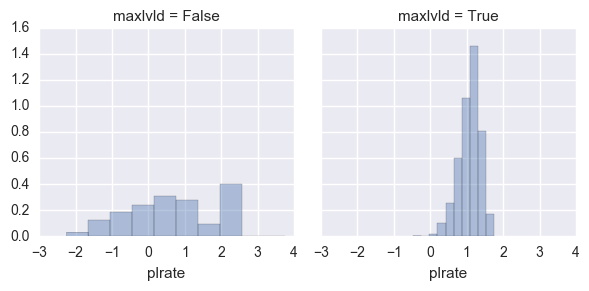

In [22]:
#Construct play rate
av_df['plrate'] = np.log10(av_df['nplays'] / av_df['baseline_td'])

g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'plrate', bins=10, kde=False, norm_hist=True)

It appears that our intuition was correct. The distributions of max leveling appear starkly different between the two sets of avatars. Avatars that reached max level (post WLK) again exhibit a somewhat lognormal distribution peaking at around 10 plays/day. In contrast, the non-max-leveled avatars illustrate a much broader distribution with less frequent play rates on average. The exception is the lonesome peak at play rates >100/day. This would seem to represent avatars that started to level quickly after WLK was released, but did not succeed before these observations ended.

## Progression rate
Again we see a strong correlation here. Let's explore another correlation. For this, we will construct another feature: prate = lvlrng / baseline, a crude estimator for the rate of progression. Essentially, this measures on average the rate of leveling per day for each avatar. Note this is very crude and assumes linearity between the two features. However, it still might be useful to check out.

Note however that we cannot simply take the average over the whole baseline. This is because progression becomes impossible at max level. Thus, if an avatar spent a significant amount of time at max level, this ratio will be artificially low. So, need to only consider the time baseline BEFORE max level was reached.

First, to get a feel of the individual features making up prate, let's plot their maxlvld distributions.

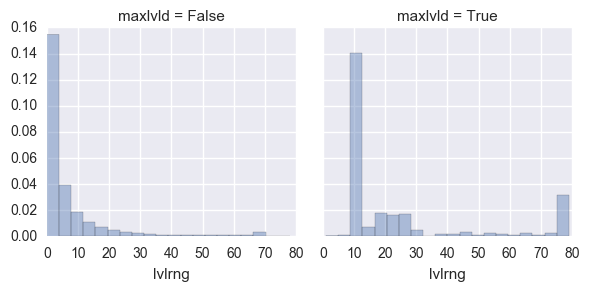

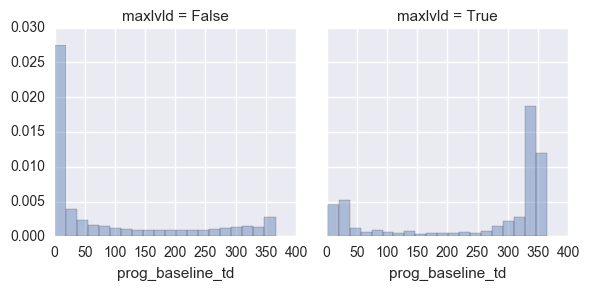

In [23]:
#Level range
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lvlrng', bins=20, kde=False, norm_hist=True)

#Progression baseline
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'prog_baseline_td', bins=20, kde=False, norm_hist=True)

The bottom plot, perhaps unsurprisingly, strongly resembles the similar one using the full baseline of observations for a character. This indicates a strong correlation between total time played and time spent leveling, which implies that most avatars are played to progress leveling. The top plot is a bit more complicated. The avatars that didn't reach max level appear to mostly have leveled < 10 levels throughout the dataset. Presumably, many (most?) of these represent avatars that were max leveled previous to the expansion (levevl 70) and then began leveling after expansion without reaching max level. Of those that did reach max level, we see a strong peak at 10 levels, indicating pre-expansion avatars that were successfully leveled to 80 post-expansion. There appears to be secondary peak at 80, indicating those new avatars that were successfully leveled from scratch post=expansion. Finally, we find a broad, tertiary peak around levels ~20. This peak is a little less transparent, but it may reflect avatars that were brought to/near max level in the original version of WoW (level 60) and not fuly leveled after Burning Crusade was released.

/Users/two-liter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


,lvlrng,prog_baseline_td,prate
count,2669.000000,2669.000000,2669.000000
mean,4.335332,266.105314,-1.887027
std,3.322884,98.846572,0.328493
min,1.000000,31.658345,-2.563468
25%,1.000000,193.832419,-2.136037
50%,3.000000,307.751794,-1.801283
75%,7.000000,347.702975,-1.582828
max,11.000000,365.989306,-1.500175


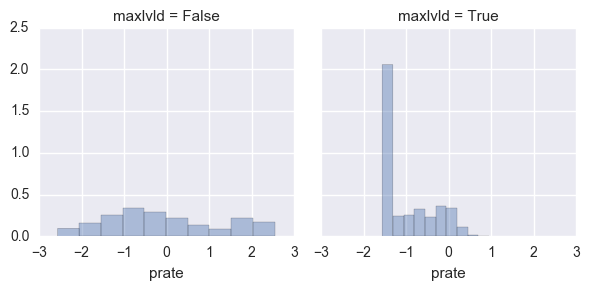

In [24]:
#Construct progression rate
av_df['prate'] = np.log10(av_df['lvlrng'] / av_df['prog_baseline_td'])
#So pandas seems to be unable to properly handle NANs, so I am just going to drop rows with prate=NaN
av_df_npr = av_df[np.isfinite(av_df['prate'])]
g = sns.FacetGrid(av_df_npr, col='maxlvld')
g.map(sns.distplot, 'prate', bins=10, kde=False, norm_hist=True)

maht = av_df_npr.loc[av_df['prate'] < -1.5, ['lvlrng', 'prog_baseline_td', 'prate']]

maht.describe()

In [25]:
av_df[['maxlvld', 'prog_baseline_td']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean', 'median'])

prog_baseline_td                                    
                     min         max        mean      median
maxlvld                                                     
False           0.000000  365.989306   90.020269   17.885938
True            2.035509  364.366991  252.491256  332.459763

In [26]:
av_df[['maxlvld', 'lvlrng']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean'])

lvlrng               
           min max       mean
maxlvld                      
False        0  78   7.058491
True         1  79  24.857981

In [27]:
av_df_npr[['maxlvld', 'prate']].groupby(['maxlvld'], as_index=False).median()

,maxlvld,prate
0,False,-0.304615
1,True,-1.381208


## How does max leveling vary with the progression rate?
So this investigation has found a few things. First, the progression rate seems to have a somewhat more complex relationship with max leveling than we might naively assume. We observe a bimodal distribution for the non-max-leveled avatars, somewhat similar to what we found for their play rates. On the other hand, the progression rates for max-leveled avatars is a bit more unexpected. It appears almost uniform for log(prate) > -1.5 with a strong, sharp peak at the slowest progression rates. This strong peak at slow progression rates is a byproduct of the way that we have constructed this feature. Specifically, we track the baseline before reaching level 80. That means if an avatar had previosuly reached the old max level (70) and was still played throughout the observations, followed by a max level after WLK release, then it will have a very long baseline and a small level range. This feature could be improved to better represent the data by adding complexity, but we do not choose to do so given the already fair amount of information provided by the other features.

## How about other more straightforward indicators of progression?
If we look at the components that consitute the prate feature, they seem to correlate with max leveling as one would expect. Namely, the time spent progressing positively correlates with achieving max level, as does the total range in level. Given that this is the case and the prate feature is a little clumsy, we may want to just use these features in the end and exclude the prate feature.

# Guild
## Does the guild affect the likelihood of max leveling?
Another feature we would like to explore is the guilds joined by the avatar. Its relation to max leveling may not be as initially straightforward as other features, but different cultures and membership of different guilds may certainly affect the likelihood that its constituent avatars reach max level. Note that an avatar can have been in multiple guilds throughout these observations, so we are forced to deal with some summary statistics. Namely, the number of guilds an avatar was in and the guild it was observed in most frequently. Let's see if these correlate with max leveling.

lognguild                         
              min  max      mean    median
maxlvld                                   
False         0.0  1.0  0.106860  0.000000
True          0.0  1.0  0.432651  0.477121

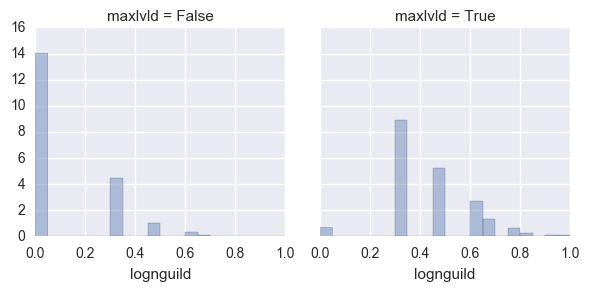

In [28]:
#Number of guilds
av_df['lognguild'] = np.log10(av_df['nguild'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognguild', bins=20, kde=False, norm_hist=True)

av_df[['maxlvld', 'lognguild']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean', 'median'])

Interestingly, we find that avatars that did not reach max level tended to reside in, on average, less guilds than those that did. The difference of the averages is ~0.3 in log space. The shapes of the distributions are also different. To summarize, avatars that reach max level tend to float between differnet guilds more frequently. Avatars which did not level to max show an overwhelmingly larger number that did not change guilds at all.

Let's also explore how the guild rate, or number of guilds averaged over the time baseline, affects the max leveling.

grate                              
              min       max      mean    median
maxlvld                                        
False   -2.563468  3.459392 -0.619100 -1.150001
True    -2.563467 -0.588128 -1.885523 -1.961044

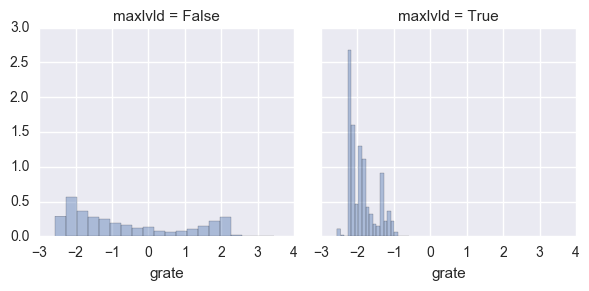

In [29]:
#Number of guilds per unit time
av_df['grate'] = np.log10(av_df['nguild'] / av_df['baseline_td'])
g = sns.FacetGrid(av_df.loc[np.isfinite(av_df['grate'])], col='maxlvld')
g.map(sns.distplot, 'grate', bins=20, kde=False, norm_hist=True)

av_df.loc[np.isfinite(av_df['grate']), ['maxlvld', 'grate']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean', 'median'])

Somewhat at odds with the previous section, it appears that those avatars who fluctuate between guilds less rapidly achieve max level more frequently than those who float back and forth between many guilds quickly. Apparently, loyalty to a guild correlates with leveling. This makes sense since that loyalty results in emotional investment and social bonds that reinforce gameplay.

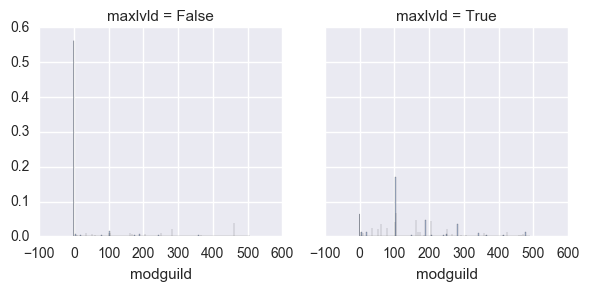

In [30]:
#Most frequented guild
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'modguild', bins=ng, kde=False, norm_hist=True)

In line with out initial assumption, different guilds tend to promote max leveling more. There also appears to be one guild that tends to disfavor max leveling significantly more than the others. Finally, an avatar is overwhelmingly less likely to reach max level if it did not belong to a guild (strong peak at -1). Thus, the social aspect of guilds is an immensely important one to WoW. One potentialy interesting thing to explore later is specific details of these most level progressive guilds to determine what distinguishes successful guilds from those that are less so. (Note: I am defining 'successful' here as a guild's tendency to promote max leveling. There are surely others ways to do so.)

# Location
Finally, let us explore another categorical feature on whether or not an avatar reached max level: locations frequented. We will explore two features related to this similar to the guild features: the number of lcoations frequented, and the most frequented location.

lognzon                              
              min       max      mean    median
maxlvld                                        
False    0.000000  2.082785  0.510030  0.301030
True     0.954243  2.161368  1.881609  1.924279

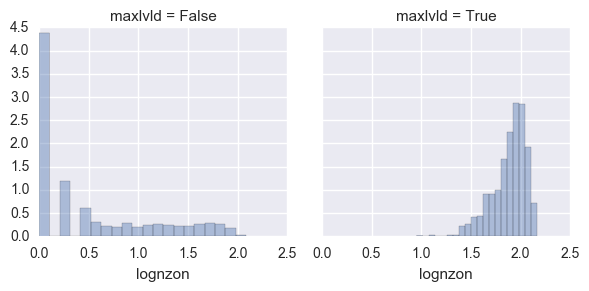

In [31]:
av_df['lognzon'] = np.log10(av_df['nzon'])
g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'lognzon', bins=20, kde=False, norm_hist=True)

av_df[['maxlvld', 'lognzon']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean', 'median'])

Again we see a pretty strong correlation in maxlvld with the number of unique zones visited. Clearly most avatars who only visited one unique location didn't seem to level much. On the other hand, those that did achive max level on average visited over an order of magnitude more unique locations. This may simply be reflecting the fact that as more time is spent playing, an avatar is more likely to visit new locations.

As with the guilds, it may be more important to factor in how many locations an avatar vists in a timespan. Thus, we will create a location rate feature, which measures how quickly an avatar moves between different locations. 

grate                              
              min       max      mean    median
maxlvld                                        
False   -2.563468  3.459392 -0.619100 -1.150001
True    -2.563467 -0.588128 -1.885523 -1.961044

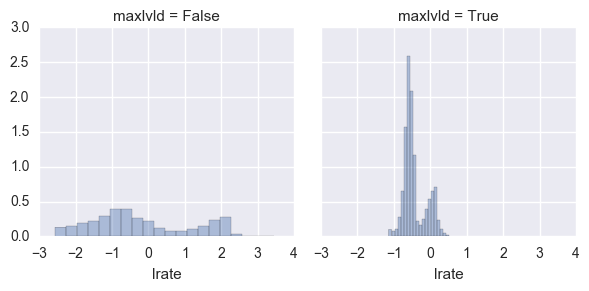

In [32]:
#Number of locations per unit time
av_df['lrate'] = np.log10(av_df['nzon'] / av_df['baseline_td'])
g = sns.FacetGrid(av_df.loc[np.isfinite(av_df['lrate'])], col='maxlvld')
g.map(sns.distplot, 'lrate', bins=20, kde=False, norm_hist=True)

av_df.loc[np.isfinite(av_df['lrate']), ['maxlvld', 'grate']].groupby(['maxlvld'], as_index=False).agg(['min', 'max', 'mean', 'median'])

Again, we see that when we control for the time baseline of observations, the location rate is a bit more nuanced than simply the number of locations visited. However, there does appear to be a correlation here as well. What we find is that avatars that achieved max level visited on average less locations per unit time than those who did not. While a bit mysterious at first glance, this may have to do with the fact that reaching max level requires a bit more grinding in certain areas than simply progressing through the lower levels.

(158, 420)


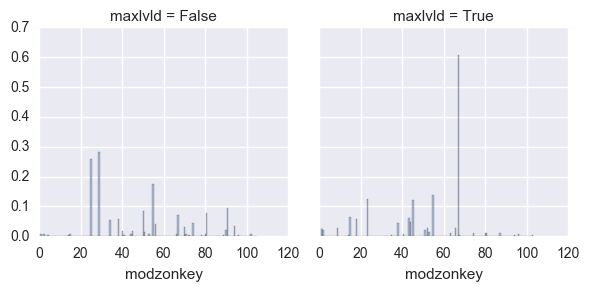

In [33]:
#Most frequented location
#For this, we need to convert the categorical modzon feature to a numerical one
#Use get_dummies for this
av_df_dum = pd.get_dummies(av_df['modzon'] , columns=['modzon'])

av_df['modzonkey'] = av_df_dum.values.argmax(1)

g = sns.FacetGrid(av_df, col='maxlvld')
g.map(sns.distplot, 'modzonkey', bins=nl, kde=False, norm_hist=True)
print(nl, ng)

Finally, we do again see clear indications that visiting certain locations is strongly correlated with reaching max level. This again is in good agreement with out intuition. Certain locations contain quests, beasts, other game features that cater more towards certain level bands. Thus, we may want to include modzon in the features for the final model.

# Fit model to predict whether avatars max leveled or not

In [34]:
#First, we need to convert the categorical variables to dummy variables for compatibility with standard algorithms
#pandas has the get_dummies function which does just this
#Make dummy variables
av_df_dum = pd.get_dummies(av_df, columns=['race', 'charclass', 'modzon', 'modguild'])

#Next, split dataset up into training and test set
#Get rid of NaN rates
av_df_dum = av_df_dum.loc[(np.isfinite(av_df_dum['plrate'])) & (np.isfinite(av_df_dum['prate']))]
#We also want to get ridof many features. We want to remove all features that are cumulative over the time coverage 
# because the model loses its predictive power if it needs to know all these details over the specific time baseline
#We also remove the number of races and classes, since these have been cleaned to all be identically 1
X = av_df_dum.drop(['nrace', 'ncharclass', 'char', 'lastplay', 'firstplay', 'baseline', 'prog_baseline', 
                    'nzon', 'nguild', 'baseline_td', 'prog_baseline_td', 'nplays', 'lvlrng', 
                    #'prate', 'plrate', 'grate', 'lrate'
                    'maxlvl',
                    'maxlvld', 'maxlvld_preWLK'
                    ], axis=1).copy()
X['preWLK'] = X['preWLK'].astype(int)
X['postWLK'] = X['postWLK'].astype(int)
y = av_df_dum['maxlvld']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.info()

X_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13951 entries, 15266 to 34253
Columns: 484 entries, avglvl to modguild_508
dtypes: float64(8), int64(3), uint8(473)
memory usage: 7.6 MB


,avglvl,preWLK,postWLK,lognplays,plrate,prate,lognguild,grate,lognzon,lrate,...,modguild_490,modguild_491,modguild_492,modguild_495,modguild_496,modguild_500,modguild_501,modguild_502,modguild_507,modguild_508
count,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,13951.000000,...,13951.000000,13951.0,13951.000000,13951.0,13951.0,13951.000000,13951.000000,13951.000000,13951.0,13951.000000
mean,24.033867,0.629991,0.153752,1.706667,0.813648,-0.114052,0.131806,-0.761213,0.687066,-0.205953,...,0.000143,0.0,0.000072,0.0,0.0,0.000358,0.000072,0.000215,0.0,0.000072
std,25.013567,0.482824,0.360724,0.960145,0.993824,1.308270,0.193473,1.421551,0.671430,1.132446,...,0.011973,0.0,0.008466,0.0,0.0,0.018929,0.008466,0.014663,0.0,0.008466
min,1.051282,0.000000,0.000000,0.301030,-2.194437,-2.563467,0.000000,-2.563467,0.000000,-2.562832,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.000000,0.000000,0.000000,0.903090,0.104571,-1.113296,0.000000,-1.957005,0.000000,-0.981609,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,10.333333,1.000000,0.000000,1.544068,0.789336,-0.344641,0.000000,-1.221237,0.477121,-0.491081,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
75%,48.604084,1.000000,0.000000,2.414973,1.493049,0.820529,0.301030,0.130878,1.255273,0.415740,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
max,79.872690,1.000000,1.000000,4.210746,2.715100,2.538574,1.000000,2.480148,2.161368,2.581446,...,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000


Thus, we are left with only race, class, and most frequented guilds and locations as features for the model. Additionally, we include whether or not an avatar was created before or after the WLK expansion since this obviosuly has a huge bearing on the max level. Finally, we include only time baseline-independent numerical features: the average level and the play, progression, guild, and location rates. We do not want our model dependent upon how long an avatar has been observed for in order to increase the generality of the model.

In [35]:
#Fit a logistic regression model to the maxlvld data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

98.46

In [36]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
8,lognzon,2.708534
5,prate,2.061633
9,lrate,2.018471
113,modzon_The Storm Peaks,1.422327
69,modzon_Icecrown,1.405718
129,modzon_Zul'Drak,1.122156
314,modguild_291,0.756077
94,modzon_Sholazar Basin,0.675222
122,modzon_Warsong Gulch,0.673856
6,lognguild,0.648176


# Evaluating the model

So evidently, this model works really well. It has extremely high scores when predicting max leveling on the test set. Yay! Some interesting things to note. 

1) The top few rows show the features most correlated with max leveling. Most of the most strongly correlated features are locations and guilds. Aside from those, we see the play rate, progression rate, and location rate to all be important factors in determining whether one of these avatars reaches max level or not.

2) On the other side of things, we see certain locations strongly correlated with not acheiving max level. Few guilds are negatively correlated with max leveling (supporting our previous assertion that being in any guild probably increases max leveling probability). Indeed, we see the no guild feature being very strongly anti-correlated with max leveling. We also see a few races and classes anti-correlated with max leveling. Again, this may simply be an artifact of the discontinuous nature of the WLK expansion and/or the strange avatars with varying races/classes. 

3) The pre and post-WLK flags are the strongest anti-correlated with max leveling. This is a result of the bias introduced by the discontinuous WLK release.

But wait... is this score too good to be true. Let's investigate for possible overfitting using learning curves.

<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

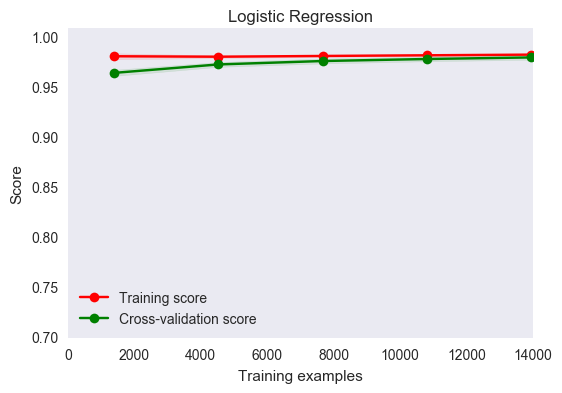

In [37]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(LogisticRegression(), 'Logistic Regression', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

This learning curve shows that the model is being pretty well fit for both the training and cross-validation sets. The fact that it does equally as well on the CV set indicates that overfitting may actually not be a problem.

Let's also examine the precision and recall of the model.

In [38]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98919568  0.75641026]
[ 0.98860228  0.76623377]


It also appears that the model is quite precise and recalls accurately when an avatar did not reach max level. However, it appears less precise when predicitng max leveling, and recalls those avatars even worse (although in all cases, >3/4 of the labels are correclty recalled). So, this model is okay, but maybe we can do better. Or perhaps our optimization algorithm isn't the best. Let's try another one.

In [50]:
#Do the same with Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

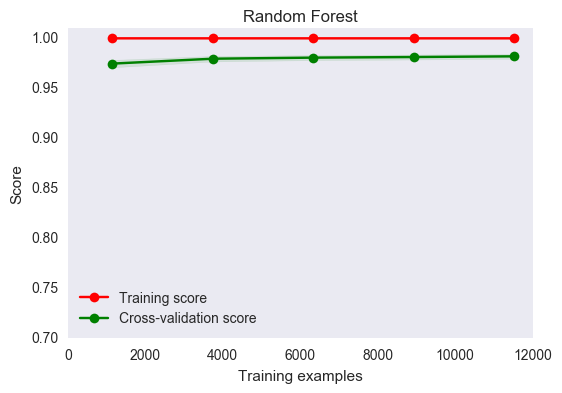

In [52]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(RandomForestClassifier(n_estimators=100), 'Random Forest', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [51]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98887122  0.91506849]
[ 0.98769353  0.92265193]


So, random forest performs simialrly to logistic regression in this case. However, we do see the CV learning curve to be systematically less accurate than that of the training set. This indicates that the model might be overfitting the data and that we need more training data for this model. Thus, we conclude that RF may not be the best algorithm in this case.

# Removing Wrath of the Lich King
Evidently, our chosen model performs poorly in terms of precisely and accurately recalling whether avatars reached max level or not. Different ML algorithms show this issue. Thus, maybe we need to tweak our model. In particular, it is likely that the effects of WLK on this dataset is discontinuous in time, and thus is probably mucking up things. Therefore, we will try the above again using only pre-WLK avatars. 

In [37]:
#First, we need to convert the categorical variables to dummy variables for compatibility with standard algorithms
#pandas has the get_dummies function which does just this
#Make dummy variables
av_df_dum = pd.get_dummies(av_df, columns=['race', 'charclass', 'modzon', 'modguild'])

#Next, split dataset up into training and test set
#Get rid of NaN rates and post-WLK avatars
av_df_dum = av_df_dum.loc[(np.isfinite(av_df_dum['plrate'])) & (np.isfinite(av_df_dum['prate'])) & (~av_df_dum['postWLK'])]
#We also want to get ridof many features. We want to remove all features that are cumulative over the time coverage 
# because the model loses its predictive power if it needs to know all these details over the specific time baseline
#We also remove the number of races and classes, since these have been cleaned to all be identically 1
X = av_df_dum.drop(['nrace', 'ncharclass', 'char', 'lastplay', 'firstplay', 'baseline', 'prog_baseline', 
                    'nzon', 'nguild', 'baseline_td', 'prog_baseline_td', 'nplays', 'lvlrng', 
                    #'prate', 'plrate', 'grate', 'lrate'
                    'maxlvl',
                    'maxlvld', 'maxlvld_preWLK', 'preWLK', 'postWLK'
                    ], axis=1).copy()

y = av_df_dum['maxlvld']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.info()

X_train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11836 entries, 10559 to 15464
Columns: 482 entries, avglvl to modguild_508
dtypes: float64(8), int64(1), uint8(473)
memory usage: 6.2 MB


,avglvl,lognplays,plrate,prate,lognguild,grate,lognzon,lrate,modzonkey,race_Blood Elf,...,modguild_490,modguild_491,modguild_492,modguild_495,modguild_496,modguild_500,modguild_501,modguild_502,modguild_507,modguild_508
count,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,11836.000000,...,11836.0,11836.0,11836.0,11836.0,11836.0,11836.0,11836.0,11836.0,11836.0,11836.0
mean,22.580601,1.763796,0.768882,-0.201009,0.142257,-0.852657,0.711323,-0.283590,49.026614,0.453109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,24.275324,0.985248,1.016121,1.332364,0.200223,1.442313,0.689507,1.148025,24.327391,0.497817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.051282,0.301030,-2.194437,-2.563468,0.000000,-2.563467,0.000000,-2.561648,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4.000000,0.954243,0.029686,-1.228444,0.000000,-2.027670,0.000000,-1.077570,29.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,9.819410,1.602060,0.744789,-0.492460,0.000000,-1.420942,0.477121,-0.580655,40.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,38.711106,2.537819,1.426395,0.740006,0.301030,0.040948,1.301030,0.288366,70.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,78.612706,4.200933,2.715100,2.538574,1.000000,2.480148,2.161368,2.581446,104.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#Fit a logistic regression model to the maxlvld data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

97.84

In [39]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
6,lognzon,3.539575
7,lrate,2.081143
3,prate,1.636952
111,modzon_The Storm Peaks,1.113161
209,modguild_156,1.053833
461,modguild_471,0.995373
115,modzon_Tirisfal Glades,0.935605
4,lognguild,0.853197
429,modguild_424,0.845838
87,modzon_Serpentshrine Cavern,0.770022


<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

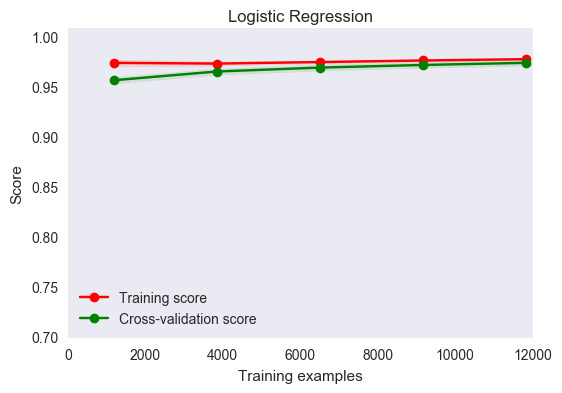

In [40]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(LogisticRegression(), 'Logistic Regression', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [41]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98246844  0.87037037]
[ 0.99502841  0.65277778]


We see a similar result, with actually a poorer accuracy than the initial model. The model has a difficult time recovering the max leveled avatars with sufficient accuracy. Let us try one more iteration of the model. In this case, we will use the max leveled prior to WLK on these pre-WLK avatars. Note that for this case, we need to recalculate many of the features previously constructed over the whole range of observations, this time restricting things to pre-WLK data.

In [45]:
#Recalculate progression metrics restricting to pre-WLK
#In this case, we will just reconstruct the avatar dataframe using only observations from the original wow_df pre-WLK
wow_df = wow_df.loc[wow_df['timestamp'] < WLK_RD]

#Make the new dataframe for progression quantities
av_prewlk_df = pd.DataFrame({'char': chars}).sort_values(by='char')

#Note that as another exploration for this dataset has found:
#(https://www.kaggle.com/romainvincent/d/mylesoneill/warcraft-avatar-history/exploration)
# that here seems to be several avatars that mysteriously change race throughout the observations.
#So we want to also calculate the number of unique races and classes for each avatar as well
#Number of races per avatar
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'race']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'race':'nrace'})
#Number of classes per avatar
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'charclass']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'charclass':'ncharclass'})

#Inclue the race and character class
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'race']].groupby(['char'], as_index=False).agg(
        lambda x: x.value_counts().index[0]), on='char')
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'charclass']].groupby(['char'], as_index=False).agg(
        lambda x: x.value_counts().index[0]), on='char')

#Get mean levels and merge with av_df
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False).mean(), on='char')
#And rename column to be more appropriate
av_prewlk_df = av_prewlk_df.rename(columns={'level':'avglvl'})

#Max level
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False).max(), on='char')
#And rename column to be more appropriate
av_prewlk_df = av_prewlk_df.rename(columns={'level':'maxlvl'})

#Reach max level?
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False)\
                    .agg(lambda x: np.size(np.where(x >= MAX_LEVEL1)[0]) > 0), on='char')
#And rename column to be more appropriate
av_prewlk_df = av_prewlk_df.rename(columns={'level':'maxlvld'})

#Level range
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'level']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
#And rename column to be more appropriate
av_prewlk_df = av_prewlk_df.rename(columns={'level':'lvlrng'})

#Number unique of guilds
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'guild']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'guild':'nguild'})

#Most frequented guild
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'guild']].groupby(['char'], as_index=False).agg(lambda x: x.value_counts().index[0]),
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'guild':'modguild'})

#Most frequented location
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'zone']].groupby(['char'], as_index=False).agg(lambda x: x.value_counts().index[0]), 
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'zone':'modzon'})

#Number unique of locations
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'zone']].groupby(['char'], as_index=False).agg(lambda x: len(x.unique())), 
            on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'zone':'nzon'})

#Number of data points for this avatar (i.e. frequency of playing)
av_prewlk_df = av_prewlk_df.merge(pd.DataFrame(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).count()), on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'timestamp':'nplays'})

#Last recorded play timestamp
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).max(), on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'timestamp':'lastplay'})

#First recorded play timestamp
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False).min(), on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'timestamp':'firstplay'})

#And total time baseline
av_prewlk_df = av_prewlk_df.merge(wow_df[['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'timestamp':'baseline'})
#Convert this time delta to just a float number of days
av_prewlk_df['baseline_td'] = av_prewlk_df['baseline'].dt.total_seconds() / (24 * 60 * 60)

#Also want to know time spent actually progressing before max level was reached
av_prewlk_df = av_prewlk_df.merge(wow_df.loc[wow_df['level'] < MAX_LEVEL2, 
                               ['char', 'timestamp']].groupby(['char'], as_index=False)\
                    .agg(lambda x: x.max() - x.min()), on='char')
av_prewlk_df = av_prewlk_df.rename(columns={'timestamp':'prog_baseline'})
av_prewlk_df['prog_baseline_td'] = av_prewlk_df['prog_baseline'].dt.total_seconds() / (24 * 60 * 60)

#Now calculate rates
#Number of guilds per unit time
av_prewlk_df['grate'] = np.log10(av_prewlk_df['nguild'] / av_prewlk_df['baseline_td'])
#Number of locations per unit time
av_prewlk_df['lrate'] = np.log10(av_prewlk_df['nzon'] / av_prewlk_df['baseline_td'])
#Construct play rate
av_prewlk_df['plrate'] = np.log10(av_prewlk_df['nplays'] / av_prewlk_df['baseline_td'])
#Construct progression rate
av_prewlk_df['prate'] = np.log10(av_prewlk_df['lvlrng'] / av_prewlk_df['prog_baseline_td'])

#First, we need to convert the categorical variables to dummy variables for compatibility with standard algorithms
#pandas has the get_dummies function which does just this
#Make dummy variables
av_df_dum = pd.get_dummies(av_prewlk_df, columns=['race', 'charclass', 'modzon', 'modguild'])

#Next, split dataset up into training and test set
#Get rid of NaN rates and post-WLK avatars
av_df_dum = av_df_dum.loc[(np.isfinite(av_df_dum['plrate'])) & (np.isfinite(av_df_dum['prate']))]
#We also want to get ridof many features. We want to remove all features that are cumulative over the time coverage 
# because the model loses its predictive power if it needs to know all these details over the specific time baseline
#We also remove the number of races and classes, since these have been cleaned to all be identically 1
X = av_df_dum.drop(['nrace', 'ncharclass', 'char', 'lastplay', 'firstplay', 'baseline', 'prog_baseline', 
                    'nzon', 'nguild', 'baseline_td', 'prog_baseline_td', 'nplays', 'lvlrng', 
                    #'prate', 'plrate', 'grate', 'lrate'
                    'maxlvl', 'maxlvld'], axis=1).copy()

y = av_df_dum['maxlvld'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.info()

X_train.describe(include='all')

/Users/two-liter/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:100: RuntimeWarning: divide by zero encountered in log10


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11522 entries, 9197 to 15970
Columns: 454 entries, avglvl to modguild_472
dtypes: float64(5), uint8(449)
memory usage: 5.5 MB


,avglvl,grate,lrate,plrate,prate,race_Blood Elf,race_Orc,race_Tauren,race_Troll,race_Undead,...,modguild_457,modguild_459,modguild_460,modguild_463,modguild_465,modguild_466,modguild_467,modguild_468,modguild_471,modguild_472
count,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,...,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.000000,11522.0,11522.0,11522.000000,11522.0
mean,18.977128,-0.743398,-0.233346,0.789757,-0.073438,0.475352,0.092085,0.166464,0.099288,0.166811,...,0.000694,0.000694,0.015188,0.000781,0.000087,0.000087,0.0,0.0,0.000087,0.0
std,21.070471,1.424915,1.159342,1.029425,1.290678,0.499414,0.289158,0.372513,0.299062,0.372824,...,0.026342,0.026342,0.122307,0.027939,0.009316,0.009316,0.0,0.0,0.009316,0.0
min,1.038961,-2.507843,-2.506617,-2.029827,-2.507715,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
25%,3.777778,-1.925743,-1.076507,0.026002,-1.054668,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
50%,8.650605,-1.236478,-0.522857,0.753285,-0.328407,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
75%,26.860233,0.178628,0.449950,1.543357,0.862643,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
max,69.996597,2.480148,2.581446,2.715100,2.932192,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0


In [46]:
#Fit a logistic regression model to the maxlvld data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

98.46

In [47]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,plrate,2.282766
4,prate,2.023767
63,modzon_Netherstorm,1.467375
56,modzon_Karazhan,1.408969
55,modzon_Isle of Quel'Danas,1.385327
76,modzon_Shattrath City,1.328861
21,modzon_Arathi Basin,1.199901
75,modzon_Shadowmoon Valley,1.023814
347,modguild_336,0.883169
20,modzon_Alterac Valley,0.822786


<module 'matplotlib.pyplot' from '/Users/two-liter/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

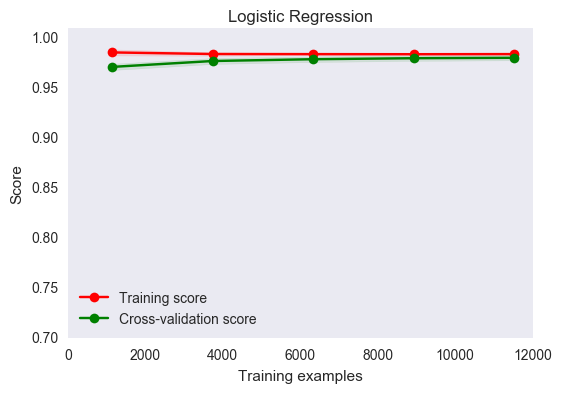

In [48]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

plot_learning_curve(LogisticRegression(), 'Logistic Regression', X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [49]:
pr, rec, fsc, sup = precision_recall_fscore_support(y_test, y_pred, average=None)
print(pr)
print(rec)

[ 0.98847835  0.91483516]
[ 0.98769353  0.9198895 ]


We see that after removing WLK data from this set, the predictive power of this model is greatly imporoved. With precisions and recalls > 85% for both classes of avatars and no apparent overfitting, we conclude that this model should do a decent job at predicting whether or not an avatar will reach max level given some time-series observations. Note that the results are really only valid for Burning Crusade era avatars. The above analysis indicates that each expansion era needs to be treated completely separately in order to make a strong model. We could try to do the same for the exclusively post-WLK avatars in ths dataset, however the small number and short time baseline for these avatars probably would not yield good results. We would need more data.

# Conclusions
So we found that this complicated model with many (~500) features can do a good job at predicting whether or not an avatar reaches max level. In particular, we found that race, class, guilds, and frequented locations all correlate strongly with max leveling, along with its level. It was found that the WLK expansion completely mucked up this predictive model. Thus, we conclude from this that such analyses need to be considered on a expansion-by-expansion basis. In terms of real-world applicability, such a model could potentially be used to track individual avatars and estimate whether or not they will be played to max level. Developers could then trace these avatars to individual players and use this information to better understand why some players might stop playing (e.g. stop max leveling?). Unfortunately, this dataset does not provide any information on players themselves, so no such analysis is possible here. One final note about these results: the caveat about the race/class swapping avatars need to be considered when deciding whether or not this model can be generalized to an arbitrary avatar. In particular, the reason for these inconsistencies needs to be better understood, along with any potential biases they introduce into the data.